In [35]:
import pandas as pd

# Read test and training set 
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

First of all have a brief look at the data. Understand the structure of the data. 

In [36]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I'll do Data Cleaning first. Exclude columns that I won't use, handle missing values.

In [37]:
columns_to_exclude = ['Ticket']
train_data_cleaned = train_data.drop(columns=columns_to_exclude)

# Check missing values 
missing_values_count = train_data_cleaned.isnull().sum()
missing_values_count[0:10]

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
dtype: int64

Dealing with missing values. For embarked we only have 2 missing values, so I am going to put the most common port of embarkation here. For age I could use mean value based on gender and fill it in. This seems to be the most natural solution. More than half the values for Cabin are missing. I could remove this column, but the missing information may be useful later in the feature engineering phase. 

In [38]:
# Calculate average age for males and females
average_male_age = train_data[train_data['Sex'] == 'male']['Age'].mean()
average_female_age = train_data[train_data['Sex'] == 'female']['Age'].mean()

# Fill missing values in 'Age' based on gender
train_data_cleaned['Age'] = train_data_cleaned.apply(
    lambda row: average_male_age if pd.isnull(row['Age']) and row['Sex'] == 'male' else
                  average_female_age if pd.isnull(row['Age']) and row['Sex'] == 'female' else
                  row['Age'],
    axis=1
)

# Fill missing values in 'Embarked' with 'C', which is the most common cabin 
train_data_cleaned['Embarked'].fillna('C', inplace=True)

In [39]:
sex_encoded = pd.get_dummies(train_data['Sex'], prefix='Sex', drop_first=True)

train_data_cleaned['Sex'] = sex_encoded['Sex_male']
train_data_cleaned.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",True,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",False,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",True,35.0,0,0,8.0500,NaN,S


# Feature engineering 
First look at the cleaned data again. Plot the data to see relationships and patterns. 

In [40]:
train_data_cleaned.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.736034,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.014897,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The first thing I want to look at is the difference in survival between men and women. Plot the graph showing the number of surviving males and females.

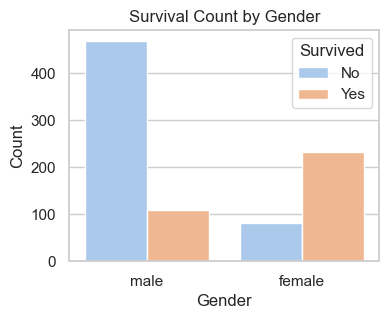

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(4, 3))
sns.countplot(x='Sex', hue='Survived', data=train_data, palette='pastel')

# Add labels and title
plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Add legend
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

# Show the plot
plt.show()



The first thing  I would like to do that would help me to create new features is to have a look at titles extracted from names. We know that women tend to survive more, but I can assume that women with the title Mrs could survive more. I remember from the data cleaning stage that we had a lot of missing values in the Cabin column. It may be useful to create a new feature based on whether the 'Cabin' information is present or absent (NaN).

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


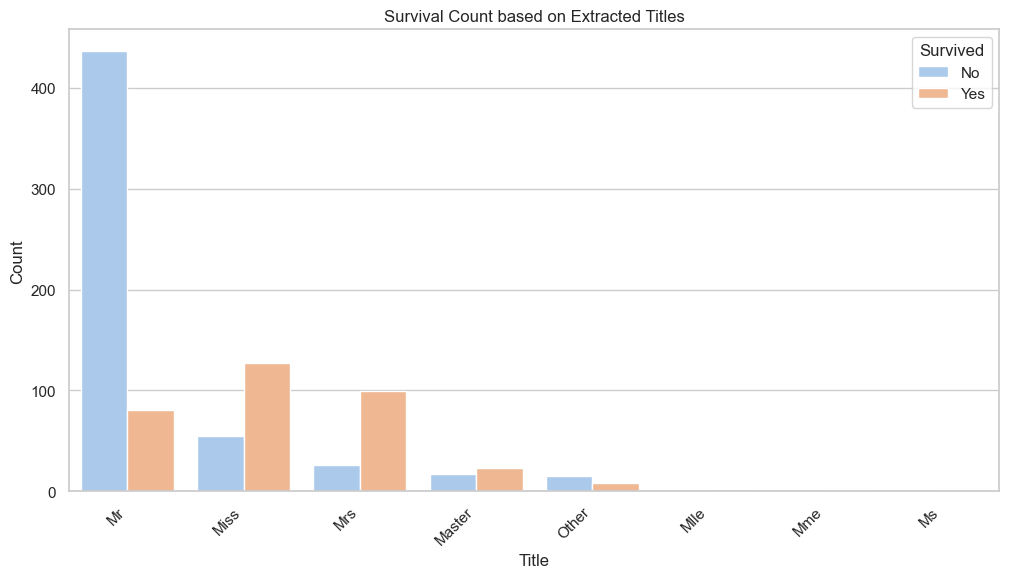

In [42]:
# Extract titles from the 'Name' column
train_data_cleaned['Title'] = train_data_cleaned['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Display unique titles and their counts
print(train_data_cleaned['Title'].value_counts())

# Combine less common titles into a general category
train_data_cleaned['Title'] = train_data_cleaned['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Countess', 'Lady', 'Sir', 'Jonkheer', 'Don', 'Dona'], 'Other')

# Encoding of the Cabin column 
train_data_cleaned['Cabin_Present'] = train_data_cleaned['Cabin'].notnull().astype(int)

plt.figure(figsize=(12, 6))
sns.countplot(x='Title', hue='Survived', data=train_data_cleaned, palette='pastel', order=train_data_cleaned['Title'].value_counts().index)

# Add labels and title
plt.title('Survival Count based on Extracted Titles')
plt.xlabel('Title')
plt.ylabel('Count')

# Add legend
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

We can see that females with the title Miss tend to survive more. I can create a new feature related to titles, as there are mostly Mr, Miss and Mr titles, I will use the values 0, 1, 2, 3 to encode these titles and others. I would also chech if the title is rare as passengers with rare titles tend to survive more. 

In [45]:
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2}
train_data_cleaned['Title_Encoded'] = train_data_cleaned['Title'].map(title_mapping).fillna(3).astype(int)

# Feature indicating marital status
train_data_cleaned['Married'] = (train_data_cleaned['Title'] == 'Mrs').astype(int)

# Identify rare titles
rare_titles = train_data_cleaned['Title'].value_counts()[train_data_cleaned['Title'].value_counts() < 10].index
train_data_cleaned['Is_Rare_Title'] = train_data_cleaned['Title'].isin(rare_titles).astype(int)